In [1]:
# general imports
from math import pi
import json
import time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from braket.aws import AwsDevice
from braket.circuits import Circuit
from braket.devices import Devices

%matplotlib inline

In [3]:
device = AwsDevice(Devices.Rigetti.Ankaa3)

execution_windows = device.properties.service.executionWindows
connectivity_graph = device.properties.paradigm.connectivity
calibration = device.properties.standardized.dict()

print(f"The availability windows for {device.name}:\n{execution_windows}\n")
print(f"The connectivity graph of the qubits for this device:\n {connectivity_graph}\n")
# print("Calibration data:\n", json.dumps(calibration, sort_keys=True, indent=2))
with open('Ankaa-3_Braket_Qubit_Calibration.json', 'w', encoding='utf-8') as f:
    json.dump(calibration, f, indent=4) # 'indent=4' makes the file human-readable


The availability windows for Ankaa-3:
[DeviceExecutionWindow(executionDay=<ExecutionDay.EVERYDAY: 'Everyday'>, windowStartHour=datetime.time(0, 0), windowEndHour=datetime.time(6, 59, 59)), DeviceExecutionWindow(executionDay=<ExecutionDay.EVERYDAY: 'Everyday'>, windowStartHour=datetime.time(9, 0), windowEndHour=datetime.time(19, 0)), DeviceExecutionWindow(executionDay=<ExecutionDay.EVERYDAY: 'Everyday'>, windowStartHour=datetime.time(21, 0), windowEndHour=datetime.time(23, 59, 59))]

The connectivity graph of the qubits for this device:
 fullyConnected=False connectivityGraph={'0': ['1', '7'], '1': ['0', '2', '8'], '2': ['1', '3', '9'], '3': ['2', '4', '10'], '4': ['3', '5', '11'], '5': ['4', '6', '12'], '6': ['5', '13'], '7': ['0', '8', '14'], '8': ['1', '7', '9', '15'], '9': ['2', '8', '10', '16'], '10': ['3', '9', '11', '17'], '11': ['4', '10', '12', '18'], '12': ['5', '11', '13', '19'], '13': ['6', '12', '20'], '14': ['7', '15', '21'], '15': ['8', '14', '16', '22'], '16': ['9', '15'

In [72]:
print("The native gates for the", device.name, "device are:")
for gate in device.properties.paradigm.nativeGateSet:
    print(gate)

The native gates for the Ankaa-3 device are:
rx
rz
iswap


Initializing solver...
Graph Degree: 4. Solving with max 5 circuits.
----------------------------------------
VERIFICATION REPORT
----------------------------------------
Total Number of Circuits:    4
Total Unique Edges in Graph: 140
Unique Edges Tested:         140
Total Tests Performed:       152 (Avg 1.09x redundancy)
Coverage:                    100.0%

[PASS] All connections tested at least once.
----------------------------------------

DONE in 0.0027 seconds.
Total Edges in Graph: 140
------------------------------
Efficiency: 0.975609756097561


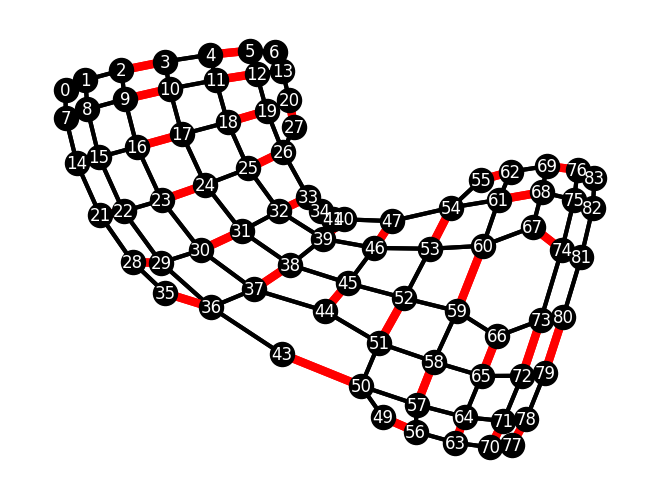

Efficiency: 0.9512195121951219


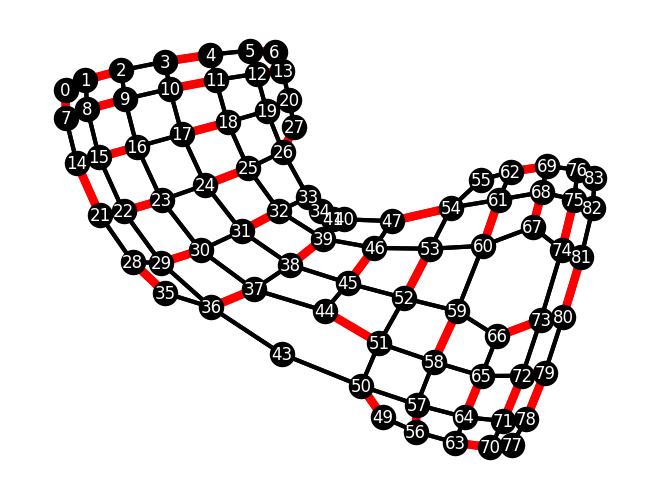

Efficiency: 0.8780487804878049


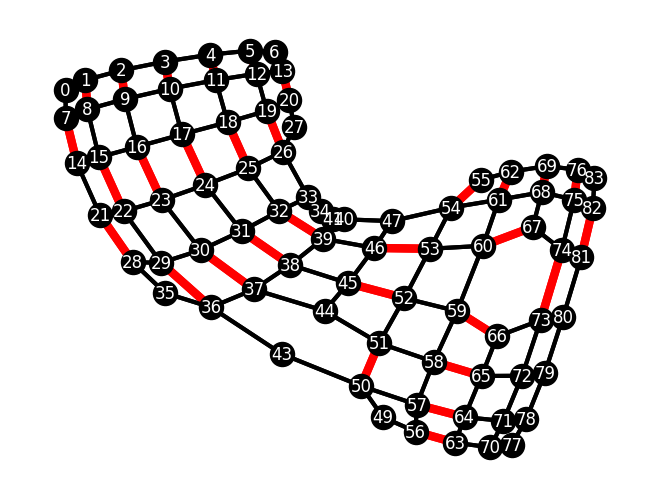

Efficiency: 0.9024390243902439


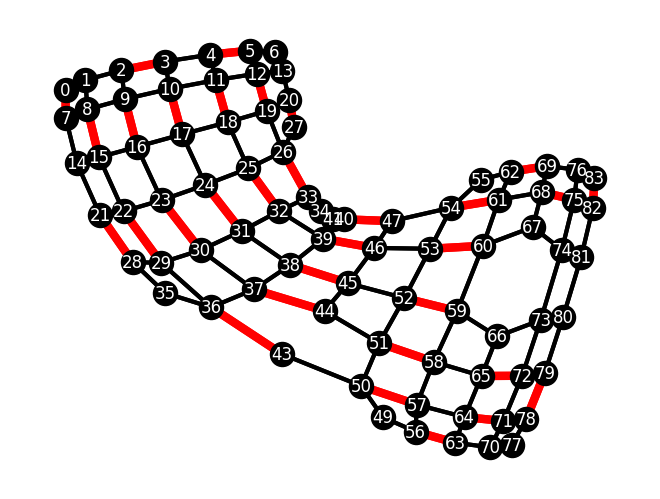

In [5]:
import graphconnector as gc

G = device.topology_graph

start_time = time.time()
print("Initializing solver...")
total_connectivity = device.properties.paradigm.connectivity.connectivityGraph
qubits = [qub for qub in total_connectivity]
qubits.sort(key=float)

final_sets, solver = gc.generate_circuits(total_connectivity, max_sets=4, compaction = True, redundancy = True)

end_time = time.time()

print(f"\nDONE in {end_time - start_time:.4f} seconds.")
print(f"Total Edges in Graph: {len(solver.all_edges)}")
print("-" * 30)

for i in range(len(final_sets)):
    
    red_edges = list(final_sets[i])
    connected_qubits = [str(qub_pair[0]) for qub_pair in red_edges] + [str(qub_pair[1]) for qub_pair in red_edges]
    connected_qubits.sort(key=float)
    # print("Connected Qubits:\n",connected_qubits,"\n")
    # print("Total Qubits:\n",qubits,"\n")
    print("Efficiency:", len(connected_qubits)/len(qubits))
    
    # 3. Create a color map based on G.edges()
    edge_colors = []
    widths = []
    for u, v in G.edges():
        u = str(u)
        v = str(v)
        # Check if the edge (or its reverse) is in your red_subset
        if (u, v) in red_edges or (v, u) in red_edges:
            edge_colors.append('red')
            widths.append(6)
        else:
            edge_colors.append('black')
            widths.append(3)
    
    black_edges = [e for e in G.edges() if e not in red_edges and (e[1], e[0]) not in red_edges]

    if i == 0:
        pos = nx.forceatlas2_layout(G)
    nx.draw(G, pos, with_labels=True, edge_color=edge_colors, node_color = 'black' ,font_color="white", width = widths, arrows=False)
    plt.show()


In [22]:
i % 7 > 3

False

In [64]:
full_set = final_sets[3]
bottom_half = set()
top_half = set()

for i,j in final_sets[3]:
    if (int(i) % 7 > 3):
        # print((i,j))
        bottom_half.add((i,j))

for k in final_sets[3]:
    if k not in bottom_half:
        top_half.add(k)

print(bottom_half)
print(top_half)

{('39', '46'), ('20', '27'), ('12', '19'), ('11', '18'), ('40', '47'), ('53', '60'), ('34', '41'), ('4', '5'), ('6', '13'), ('62', '69'), ('82', '83'), ('74', '81'), ('68', '75'), ('54', '61'), ('26', '33'), ('25', '32')}
{('64', '71'), ('9', '16'), ('36', '43'), ('8', '15'), ('21', '28'), ('56', '63'), ('22', '29'), ('65', '72'), ('52', '59'), ('70', '77'), ('0', '7'), ('51', '58'), ('50', '57'), ('2', '3'), ('10', '17'), ('23', '30'), ('78', '79'), ('37', '44'), ('24', '31'), ('38', '45'), ('73', '80')}


In [96]:
def Spin_Echo_Identity_Circuit_Ankaa_3(qubits = [1,2,3]):
    Spin_Echo_Identity = Circuit()
    for qub in qubits:
        qub_in = int(qub)
        Spin_Echo_Identity = Spin_Echo_Identity.rx(target = qub_in, angle = pi/2)
        Spin_Echo_Identity = Spin_Echo_Identity.rz(target = qub_in, angle = pi)
        Spin_Echo_Identity = Spin_Echo_Identity.rx(target = qub_in, angle = pi/2)
        Spin_Echo_Identity = Spin_Echo_Identity.rz(target = qub_in, angle = pi)
        Spin_Echo_Identity = Spin_Echo_Identity.rx(target = qub_in, angle = pi/2)
        Spin_Echo_Identity = Spin_Echo_Identity.rx(target = qub_in, angle = -pi/2)
    return Spin_Echo_Identity

def Spin_Echo_Flip_Circuit_Ankaa_3(qubits = [1,2,3]):
    Spin_Echo_Flip = Circuit()
    for qub in qubits:
        qub_in = int(qub)
        Spin_Echo_Flip = Spin_Echo_Flip.rx(target = qub_in, angle = pi/2)
        Spin_Echo_Flip = Spin_Echo_Flip.rz(target = qub_in, angle = pi)
        Spin_Echo_Flip = Spin_Echo_Flip.rx(target = qub_in, angle = pi)
        Spin_Echo_Flip = Spin_Echo_Flip.rz(target = qub_in, angle = pi)
        Spin_Echo_Flip = Spin_Echo_Flip.rx(target = qub_in, angle = pi)
        Spin_Echo_Flip = Spin_Echo_Flip.rx(target = qub_in, angle = pi/2)
    return Spin_Echo_Flip


In [79]:
ankaa_emulator = device.emulator()
Verbatim_Spin_Echo_Flip = Circuit().add_verbatim_box(Spin_Echo_Flip_Circuit_Ankaa_3([1,2,3]))

Spin_Echo_Flip_emulator_run = ankaa_emulator.run(Verbatim_Spin_Echo_Flip, shots=8192)
Spin_Echo_Flip_emulator_result = Spin_Echo_Flip_emulator_run.result()
Spin_Echo_Flip_emulator_counts = Spin_Echo_Flip_emulator_result.measurement_counts

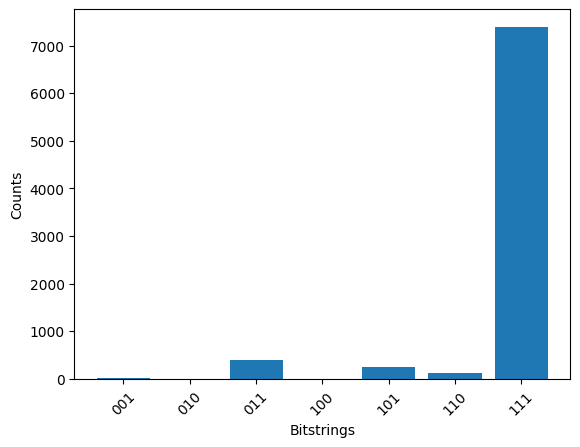

In [80]:
emulator_counts = Spin_Echo_Flip_emulator_counts
plt.bar(
    sorted(emulator_counts.keys()), [emulator_counts[k] for k in sorted(emulator_counts.keys())]
)
plt.xlabel("Bitstrings")
plt.ylabel("Counts")
plt.xticks(rotation=45)
# plt.title(emulator_counts)
plt.show()

In [97]:
ankaa_emulator = device.emulator()
Verbatim_Spin_Echo_Identity = Circuit().add_verbatim_box(Spin_Echo_Identity_Circuit_Ankaa_3([1,2,3]))

Spin_Echo_Identity_emulator_run = ankaa_emulator.run(Verbatim_Spin_Echo_Identity, shots=8192)
Spin_Echo_Identity_emulator_result = Spin_Echo_Identity_emulator_run.result()
Spin_Echo_Identity_emulator_counts = Spin_Echo_Identity_emulator_result.measurement_counts

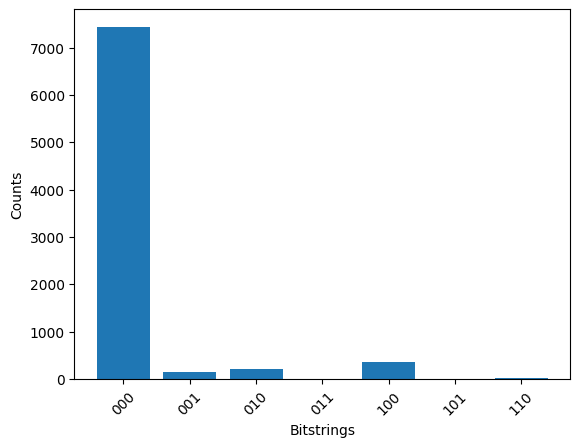

In [98]:
emulator_counts = Spin_Echo_Identity_emulator_counts
plt.bar(
    sorted(emulator_counts.keys()), [emulator_counts[k] for k in sorted(emulator_counts.keys())]
)
plt.xlabel("Bitstrings")
plt.ylabel("Counts")
plt.xticks(rotation=45)
# plt.title(emulator_counts)
plt.show()

In [99]:
total_connectivity = device.properties.paradigm.connectivity.connectivityGraph
qubits = [qub for qub in total_connectivity]
qubits.sort(key=float)
# qubits

Verbatim_Spin_Echo_Identity_Circuit = Circuit().add_verbatim_box(Spin_Echo_Identity_Circuit_Ankaa_3(qubits))
Verbatim_Spin_Echo_Flip_Circuit = Circuit().add_verbatim_box(Spin_Echo_Flip_Circuit_Ankaa_3(qubits))

In [100]:
Verbatim_Spin_Echo_Identity_task = device.run(Verbatim_Spin_Echo_Identity_Circuit, shots=8192, disable_qubit_rewiring=True)

In [124]:
Verbatim_Spin_Echo_Identity_result = Verbatim_Spin_Echo_Identity_task.result()
Verbatim_Spin_Echo_Identity_measured_qubits = Verbatim_Spin_Echo_Identity_result.measured_qubits
Verbatim_Spin_Echo_Identity_measurements = Verbatim_Spin_Echo_Identity_result.measurements
print(np.array(Verbatim_Spin_Echo_Identity_measurements).size)


np.savetxt("/home/ec2-user/SageMaker/measurement-test/Ankaa-3_data/Verbatim_Spin_Echo_Identity_measured_qubits.csv", Verbatim_Spin_Echo_Identity_measured_qubits, fmt = "%d", delimiter=",")
np.savetxt("/home/ec2-user/SageMaker/measurement-test/Ankaa-3_data/Verbatim_Spin_Echo_Identity_measurements.csv", Verbatim_Spin_Echo_Identity_measurements, fmt = "%d", delimiter=",")


671744


In [103]:
Verbatim_Spin_Echo_Flip_task = device.run(Verbatim_Spin_Echo_Flip_Circuit, shots=8192, disable_qubit_rewiring=True)

In [123]:
Verbatim_Spin_Echo_Flip_result = Verbatim_Spin_Echo_Flip_task.result()
Verbatim_Spin_Echo_Flip_measured_qubits = Verbatim_Spin_Echo_Flip_result.measured_qubits
Verbatim_Spin_Echo_Flip_measurements = Verbatim_Spin_Echo_Flip_result.measurements
print(np.array(Verbatim_Spin_Echo_Identity_measurements).size)


np.savetxt("/home/ec2-user/SageMaker/measurement-test/Ankaa-3_data/Verbatim_Spin_Echo_Flip_measured_qubits.csv", Verbatim_Spin_Echo_Flip_measured_qubits, fmt = "%d", delimiter=",")
np.savetxt("/home/ec2-user/SageMaker/measurement-test/Ankaa-3_data/Verbatim_Spin_Echo_Flip_measurements.csv", Verbatim_Spin_Echo_Flip_measurements, fmt = "%d", delimiter=",")


671744


In [109]:
def iSWAPer(qubit_set = {('1','2')}):
    iSWAPCircuit = Circuit()
    for q0,q1 in qubit_set:
        iSWAPCircuit = iSWAPCircuit.iswap(int(q0),int(q1))
    return iSWAPCircuit


In [110]:
Verbatim_Full_iSWAP_Circuit = Circuit().add_verbatim_box(iSWAPer(full_set))
Verbatim_Bottom_iSWAP_Circuit = Circuit().add_verbatim_box(iSWAPer(bottom_half))
Verbatim_Top_iSWAP_Circuit = Circuit().add_verbatim_box(iSWAPer(top_half))

In [111]:
# Verbatim_Full_iSWAP_task = device.run(Verbatim_Full_iSWAP_Circuit, shots=8192, disable_qubit_rewiring=True)

In [126]:
Verbatim_Full_iSWAP_result = Verbatim_Full_iSWAP_task.result()
Verbatim_Full_iSWAP_measured_qubits = Verbatim_Full_iSWAP_result.measured_qubits
Verbatim_Full_iSWAP_measurements = Verbatim_Full_iSWAP_result.measurements
print(np.array(Verbatim_Full_iSWAP_measurements).size)


np.savetxt("/home/ec2-user/SageMaker/measurement-test/Ankaa-3_data/Verbatim_Full_iSWAP_measured_qubits.csv", Verbatim_Full_iSWAP_measured_qubits, fmt = "%d", delimiter=",")
np.savetxt("/home/ec2-user/SageMaker/measurement-test/Ankaa-3_data/Verbatim_Full_iSWAP_measurements.csv", Verbatim_Full_iSWAP_measurements, fmt = "%d", delimiter=",")


606208


In [116]:
# Verbatim_Bottom_iSWAP_task = device.run(Verbatim_Bottom_iSWAP_Circuit, shots=8192, disable_qubit_rewiring=True)

In [125]:
Verbatim_Bottom_iSWAP_result = Verbatim_Bottom_iSWAP_task.result()
Verbatim_Bottom_iSWAP_measured_qubits = Verbatim_Bottom_iSWAP_result.measured_qubits
Verbatim_Bottom_iSWAP_measurements = Verbatim_Bottom_iSWAP_result.measurements
print(np.array(Verbatim_Full_iSWAP_measurements).size)


np.savetxt("/home/ec2-user/SageMaker/measurement-test/Ankaa-3_data/Verbatim_Bottom_iSWAP_measured_qubits.csv", Verbatim_Bottom_iSWAP_measured_qubits, fmt = "%d", delimiter=",")
np.savetxt("/home/ec2-user/SageMaker/measurement-test/Ankaa-3_data/Verbatim_Bottom_iSWAP_measurements.csv", Verbatim_Bottom_iSWAP_measurements, fmt = "%d", delimiter=",")


606208


In [119]:
# Verbatim_Top_iSWAP_task = device.run(Verbatim_Top_iSWAP_Circuit, shots=8192, disable_qubit_rewiring=True)

In [122]:
Verbatim_Top_iSWAP_result = Verbatim_Top_iSWAP_task.result()
Verbatim_Top_iSWAP_measured_qubits = Verbatim_Top_iSWAP_result.measured_qubits
Verbatim_Top_iSWAP_measurements = Verbatim_Top_iSWAP_result.measurements
print(np.array(Verbatim_Full_iSWAP_measurements).size)


np.savetxt("/home/ec2-user/SageMaker/measurement-test/Ankaa-3_data/Verbatim_Top_iSWAP_measured_qubits.csv", Verbatim_Top_iSWAP_measured_qubits, fmt = "%d", delimiter=",")
np.savetxt("/home/ec2-user/SageMaker/measurement-test/Ankaa-3_data/Verbatim_Top_iSWAP_measurements.csv", Verbatim_Top_iSWAP_measurements, fmt = "%d", delimiter=",")


606208
